In [5]:


'''
@author     : Ali Mustofa HALOTEC
@module     : OCR License Plate Indonesia
@Created on : 7 Agust 2021
'''

import sys
import cv2
import torch
import easyocr
import numpy as np
from PIL import Image, ImageDraw

sys.path.append("..")
from src.schema.config_ocr import ConfigOcr
from src.app import LicensePlateDetection
from src.app import OpticalCharacterRecognition
from config import KODE_WILAYAH_JSON


In [90]:
class OpticalCharacterRecognition:
    '''
    Load model library Ocr
    '''
    def __init__(self):
        self.device = True if torch.cuda.is_available() else False
        self.list_langs = ['en', 'id']
        self.recog_network = 'latin_g2'
        self.reader = easyocr.Reader(self.list_langs, gpu=self.device, recog_network=self.recog_network)

    def detect_char(self, image):
        '''
        Detection character in image
        Args:
            image(np.array): image for detect character
        Retrun:
            result(list): [[x_min, x_max, y_min, y_max]], []
        '''
        return self.reader.detect(image)

    def ocr_image(self, image, config):
        '''
        Read text in image with library easy ocr
        with configuration in param config
        Args:
            image(np.array): image for ocr
            config(schema.config_ocr): configuration library ocr
        Retrun
        '''
        results = self.reader.readtext(
            image,
            detail          = config.detail,
            decoder         = config.decoder,
            beamWidth       = config.beam_width,
            batch_size      = config.batch_size,
            workers         = config.workers,
            allowlist       = config.allow_list,
            blocklist       = config.blocklist,
            paragraph       = config.paragraph,
            min_size        = config.min_size,
            rotation_info   = config.rotation_info,
            # Contrast
            contrast_ths    = config.contrast_ths,
            adjust_contrast = config.adjust_contrast,
            # Text detection
            text_threshold  = config.text_threshold + 0.1 if self.device else config.text_threshold,
            low_text        = config.low_text,
            link_threshold  = config.link_threshold,
            canvas_size     = config.canvas_size,
            mag_ratio       = config.mag_ratio
        )
        return results
    
    def draw_boxes(self, image, bounds, color='yellow', width=2):
        text = []
        confidence = []
        image = Image.fromarray(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
        draw = ImageDraw.Draw(image)

        for bound in bounds:
            if bound[2] > 0.0:
                confidence.append(bound[2])
                text.append(bound[1])
                p0, p1, p2, p3 = bound[0]
                draw.line([*p0, *p1, *p2, *p3, *p0], fill=color, width=width)
        
        # Calculate AVG confidence level
        avgConf = sum(confidence)/len(confidence)
        return image, text, avgConf

In [91]:
model   = LicensePlateDetection()
ocr     = OpticalCharacterRecognition()

Load model_license_plate_iso_code.pt detection model.


Using cache found in /home/ocr/.cache/torch/hub/ultralytics_yolov5_master

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Focus                     [3, 32, 3]                    
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     19904  models.common.BottleneckCSP             [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  1    161152  models.common.BottleneckCSP             [128, 128, 3]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  1    641792  models.common.BottleneckCSP             [256, 256, 3]                 
  7                -1  1   1180672  models.common.Conv               

Adding autoShape... 


In [53]:
def detection(image):
    '''
    Detection license plate
    and filter clasess, confidence
    Args:
        image(np.array): image for cropped
    return:
        result(tuple): (
                image_cropped(np.array): image croped,
                confidence(float): confidence level,
                bbox(list): bbox detection [x_min, y_min, x_max, y_max]
            )

    '''
    result_detection = model.prediction(image)
    license_plate = model.filter_and_crop(
        img=image, results=result_detection, min_confidence=0.0
    )
    if len(license_plate[0]) >=1 and license_plate[1] > 0 and len(license_plate[2]) == 4:
        print(f'Got license plate detection confidence : {round(license_plate[1], 2)} %')
    else: print(f'License plate not found')
    return license_plate

def resize(image, height_percent=180, width_percent=180):
	'''
	resize image by percent
    Args:
        image(np.array): image
        height_percent(int): percentage height
        width_percent(int): percentage width
    Return:
        image(np.array): image resized
	'''
	height = int(image.shape[0] * height_percent / 100)
	width = int(image.shape[1] * width_percent / 100)
	dim = (width, height)
	new_img = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
	print(f'Resize image to : {new_img.shape}')
	return new_img

def detect_char(image, output=False):
    '''
    Detection charcters text in image
    Args:
        image(np.array): image.
        output(boolean): output detection default (output=False)
    Return:
        result(boolean|list): result detection character
    '''
    detected_char = ocr.detect_char(image)
    if detected_char[0]:
        print(f'Found text in image : {" ".join([str(i) for i in detected_char[0]])}')
    else:
        print(f'Not found text in image')

    if output:
        results = detected_char[0][0]
    else: 
        if detected_char[0]: results = True
        else: results = False
    return results

def read_text(image, position_text='horizontal', clasess_name='license_plate'):
    '''
    Set methods and value config ocr
    methods view schema/config_ocr.py
    Args:
        image(np.array): image for read text
        position_text(str): position text vertical/horizontal (default=vertical)
        clasess_name(str): clasess name read text (default=license_plate)
    Retrun:
        result(list): [([[28, 32], [52, 32], [52, 64], [28, 64]], 'text', 0.9846626687831872)]
    '''
    if position_text == 'horizontal':
        config = ConfigOcr(
            beam_width      = 8,
            batch_size      = 10,
            text_threshold  = 0.5,
            link_threshold  = 0.9,
            low_text        = 0.4,
            slope_ths       = 0.9,
            mag_ratio 		= 1,
            add_margin		= 0.5,
            width_ths       = 0.5
        )
    elif position_text == 'vertical':
        config = ConfigOcr(
            batch_size  	= 10,
            text_threshold 	= 0.2,
            link_threshold 	= 0.9,
            low_text 		= 0.4,
            add_margin		= 0
        )

    results = ocr.ocr_image(image=image, config=config)
    if position_text == 'horizontal': results.sort(reverse=False)
    else : results = results
    print(f'Ocr {clasess_name} : {" ".join([i[1] for i in results])}')
    return results


In [137]:
image = cv2.imread('../assets/img/15.jpeg')
try: license_plate = detection(image)
except: license_plate = (np.array([], dtype=np.uint8), 0, list())

License plate not found


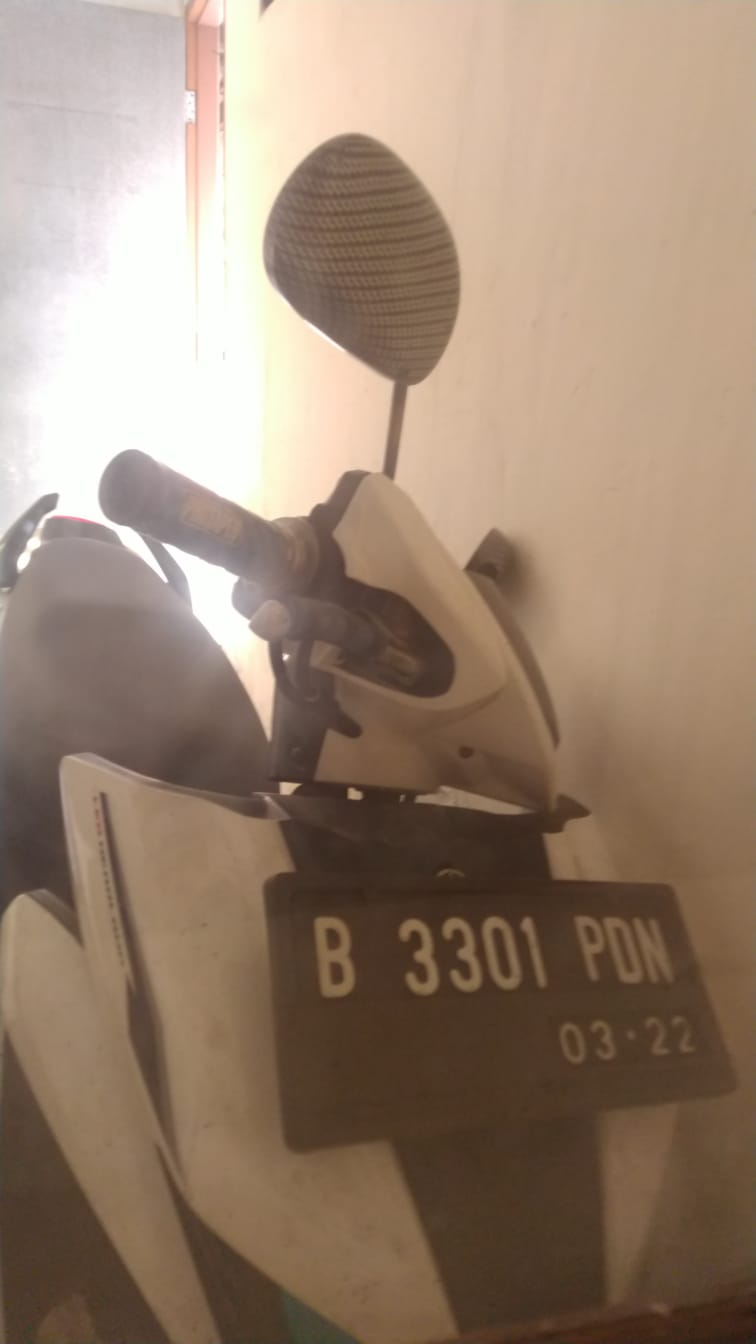

In [138]:
# Get image crop (license plate) and get bbox (license plate)
if len(license_plate[0]) >=1 and\
    license_plate[1] > 0 and\
    len(license_plate[2]) == 4:
    image_license_plate, bbox_license_plate = license_plate[0], license_plate[2]
else:
    # Get manual crop container characteristic with detect char and filter bbox character\
    image_license_plate, bbox_license_plate = image, None

Image.fromarray(cv2.cvtColor(image_license_plate, cv2.COLOR_BGR2RGB))


In [140]:
def process_license_plate(image_detection, bbox):
    if bbox:
        # Resize if width > 120
        image_crop = resize(image_detection.copy(), 200, 210) if image_detection.shape[1] < 150 else image_detection
        # Detect character in text
        detected_char = detect_char(image_crop, output=False)
        # Get image if character not found in image
        image_crop = resize(image_detection, 90, 100) if not detected_char else image_crop
    else:
        image_crop = resize(image_detection, 90, 100)
    # Process OCR
    results_ocr = read_text(image_crop, position_text='horizontal', clasess_name='license_plate')
    
    return results_ocr

results_ocr = process_license_plate(image_license_plate, bbox_license_plate)



Resize image to : (1209, 756, 3)


RuntimeError: CUDA error: the launch timed out and was terminated

# Text Processing

In [104]:
def filter_text_conf(text_conf):
    '''
    Remove space in list text_conf and add create new list
    Args:
        text_conf(list): text condidence result ocr -> [['8 1549 RFS', 0.7276318370729566]]
    Return:
        new_text_conf(list): new text confidence -> [['8', 0.7276318370729566], ['1549', 0.7276318370729566], ['RFS', 0.7276318370729566]]
    '''
    new_text_conf = list()
    for text, conf in text_conf:
        remove_space = text.split(' ')
        for word in remove_space:
            if word.isalnum():
                new_text_conf.append([word, conf])
    return new_text_conf

In [133]:
text_conf_list  = [[i[1], i[2]] for i in results_ocr]
filtered_text = filter_text_conf(text_conf_list)
print(filtered_text)

[['2', 0.4449274792036171], ['8', 0.7280487294050921], ['4728', 0.9998478293418884], ['O3', 0.8676987439918065], ['TAK', 0.9983669492750312], ['1', 0.819780780509662], ['9', 0.819780780509662], ['0', 0.08604589461837306], ['1', 0.11543068476367413]]


In [107]:
from similarity.weighted_levenshtein import WeightedLevenshtein
from similarity.weighted_levenshtein import CharacterSubstitutionInterface

'''
Add cost substituting word in compnames and result ocr
'''
class AreaCodeCharacterSubstitution(CharacterSubstitutionInterface):
	def cost(self, char_true, char_false):
		# print(c0)
		if char_true == 'B' and char_false == '8': return 0.5
		if char_true == 'A' and char_false == '7': return 0.5
		return 1.0
weighted_levenshtein_area_code = WeightedLevenshtein(AreaCodeCharacterSubstitution())

In [129]:
def get_area_code_more():
    '''
    filtered text with minimum pattren area code
    Get Area Code with algoritm weighted_levenshtein
    and update confidence (conf+1)/2
    '''
    min_ratio   = 10
    temp        = str()
    conf_i      = float()
    for text, conf in filtered_text:
        if len(text) in range(1, 4):
            text = text[1:] if text[0] in ['I', '1'] else text
            for area in KODE_WILAYAH_JSON:
                ratio = weighted_levenshtein_area_code.distance(area, text)
                if ratio < min_ratio:
                    min_ratio = ratio
                    temp = area
                    conf_i = (conf+1)/2
                else:
                    min_ratio = min_ratio
                    temp = temp
                    conf_i = conf_i
    if min_ratio < 1.5 and temp in KODE_WILAYAH_JSON:
        license_plate_dict.update({'area_code': [temp, conf_i]})
    else:
        license_plate_dict.update({'area_code': ['', 0]})

In [134]:
# get area code

# filtered_text = [['8', 0.7276318370729566], ['15A9', 0.7276318370729566], ['RF5', 0.7276318370729566]]

license_plate_dict = dict()

text_list   = [text for text,_ in filtered_text]
conf_list   = [conf for _,conf in filtered_text]
index       = [i for i,x in enumerate(text_list) if len(x) <= 2 and not x.isnumeric()]
if index:
    for idx in index:
        if text_list[idx] in KODE_WILAYAH_JSON:
            license_plate_dict.update({'area_code': [text_list[idx], conf_list[idx]]})
            break
        else: get_area_code_more()
else: get_area_code_more()


license_plate_dict

{'area_code': ['B', 0.8640243647025461]}

In [46]:
REPLACE_ABJAD2NUMBER_DICT = {
    'A': '4',
    'O': '0'
}
def replace_abjad2number(text, conf):
		license_plate = text
		confidence = conf
		for i in range(len(license_plate)):
			if not license_plate[i].isnumeric() and license_plate[i] in REPLACE_ABJAD2NUMBER_DICT:
				replaced = REPLACE_ABJAD2NUMBER_DICT[str(license_plate[i])]
				license_plate = license_plate.replace(license_plate[i], replaced)
				confidence = (conf+1)/2
		return license_plate, confidence

In [135]:
# Get number license plate
text_list   = [text for text,_ in filtered_text]
conf_list   = [conf for _,conf in filtered_text]
index       = [i for i,x in enumerate(text_list) if len(x) == 4 and  x.isnumeric()]
if index:
    for idx in index:
        license_plate_dict.update({'license_number': [text_list[idx], conf_list[idx]]})
        break
else:
    for text, conf in filtered_text:
        if len(text) in range(2, 5) and not text.isalpha() and text[0] != '0':
            if text.isnumeric():
                license_plate_dict.update({'license_number': [text, conf]})
                break
            else:
                text, conf = replace_abjad2number(text, conf)
                license_plate_dict.update({'license_number': [text, conf]})
                break
        else: license_plate_dict.update({'license_number': ['', 0]})
license_plate_dict

{'area_code': ['B', 0.8640243647025461],
 'license_number': ['4728', 0.9998478293418884]}

In [48]:
REPLACE_NUMBER2ABJAD_DICT = {
    '5': 'S',
    '0': 'O'
}
def replace_number2abjad(text, conf):
		license_plate = text
		confidence = conf
		for i in range(len(license_plate)):
			if license_plate[i].isnumeric() and license_plate[i] in REPLACE_NUMBER2ABJAD_DICT:
				replaced = REPLACE_NUMBER2ABJAD_DICT[str(license_plate[i])]
				license_plate = license_plate.replace(license_plate[i], replaced)
				confidence = (conf+1)/2
		return license_plate, confidence

In [136]:
# Get unique area
text_list   = [text for text,_ in filtered_text]
conf_list   = [conf for _,conf in filtered_text]
index       = [i for i,x in enumerate(text_list) if len(x) == 3 and x.isalpha()]
if index:
    for idx in index:
        license_plate_dict.update({'unique_are': [text_list[idx], conf_list[idx]]})
        break
else:
    for text, conf in filtered_text:
        if len(text) in range(2, 5) and not text.isnumeric() and text not in license_plate_dict['area_code'][0]:
            if text.isalpha():
                text = text[:3] if len(text) >3 else text
                license_plate_dict.update({'unique_are': [text, conf]})
                break
            else:
                text, conf = replace_number2abjad(text, conf)
                text = text[:3] if len(text) >3 else text
                license_plate_dict.update({'unique_are': [text, conf]})
        else: license_plate_dict.update({'unique_are': ['', 0]})
license_plate_dict

{'area_code': ['B', 0.8640243647025461],
 'license_number': ['4728', 0.9998478293418884],
 'unique_are': ['TAK', 0.9983669492750312]}

In [125]:
text_license_plate = f"{license_plate_dict['area_code'][0]} {license_plate_dict['license_number'][0]} {license_plate_dict['unique_are'][0]}"
conf_license_plate = round((license_plate_dict['area_code'][1]+license_plate_dict['license_number'][1]+license_plate_dict['unique_are'][1])/len(license_plate_dict), 2)
print(f'License Plate : {text_license_plate}')
print(f'Confidence : {conf_license_plate}')

License Plate : B 2562 TOR
Confidence : 0.89
